# Bathymetry data from the Caribbean 

This dataset is a compilation of several single-beam bathymetry surveys downloaded from the [NOAA NCEI](https://ngdc.noaa.gov/mgg/geodas/trackline.html). The data are originally in MGD77 format and include a header with metadata on each survey ([`MGD77_921744.h77t`](MGD77_921744.h77t)). The original data file was compressed with LZMA to save space and make it possible to upload it to this GitHub repository.

**License**: Public domain

**Original source**: https://ngdc.noaa.gov/mgg/geodas/trackline.html (region selected from the web interface; no direct download link)

In [1]:
import os
import lzma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import verde as vd
import pooch

## Load and clean the data

The dataset are LZMA compressed and are basically a tab delimited table. We can use pandas to read this directly.

In [2]:
data_full = pd.read_csv(
    "MGD77_921744.m77t.xz", 
    sep="\t", 
    usecols=[0, 4, 5, 9],
    dtype=dict(SURVEY_ID="str", LON="float64", LAT="float64", CORR_DEPTH="float64"),
).dropna().reset_index(drop=True)

Rename the columns to something easier to type, use full names, and include units.

In [3]:
data_full = data_full.rename(columns=dict(SURVEY_ID="survey_id", LAT="latitude", LON="longitude", CORR_DEPTH="depth_m"))
data_full

,survey_id,latitude,longitude,depth_m
0,FM0501,24.77290,-89.58530,3559.0
1,FM0501,24.76070,-89.57550,3561.0
2,FM0501,24.74840,-89.56560,3555.0
3,FM0501,24.73600,-89.55570,3553.0
4,FM0501,24.72380,-89.54580,3553.0
...,...,...,...,...
2354729,EW0003,9.92284,-84.72557,20.0
2354730,EW0003,9.92282,-84.72565,20.0
2354731,EW0003,9.92283,-84.72570,20.0
2354732,EW0003,9.92284,-84.72574,21.0


There is quite a bit of data so we want to slice it a bit to cover a smaller area where the bathymetry is more interesting.

In [4]:
region_latlon = (-88, -59, 7, 24)
data = data_full[vd.inside((data_full.longitude, data_full.latitude), region=region_latlon)].reset_index(drop=True)
data

,survey_id,latitude,longitude,depth_m
0,FM0501,23.13070,-87.99680,75.0
1,FM0501,23.11940,-87.98640,75.0
2,FM0501,23.10810,-87.97610,73.0
3,FM0501,23.09670,-87.96580,73.0
4,FM0501,23.08540,-87.95540,73.0
...,...,...,...,...
1938090,EW0003,9.92284,-84.72557,20.0
1938091,EW0003,9.92282,-84.72565,20.0
1938092,EW0003,9.92283,-84.72570,20.0
1938093,EW0003,9.92284,-84.72574,21.0


Calculate projected coordinates so we can plot the data for inspection.

In [5]:
proj_string = f"+proj=cea +ellips=WGS84 +lat_ts={np.mean(region_latlon[2:]):.1f} +lon_0={np.mean(region_latlon[:2]):.1f}"
projection = pyproj.Proj(proj_string)
coordinates = projection(data.longitude.values, data.latitude.values)
region = vd.get_region(coordinates)

Plot the full data to see what we have.

Text(0, 0.5, 'northing (m)')

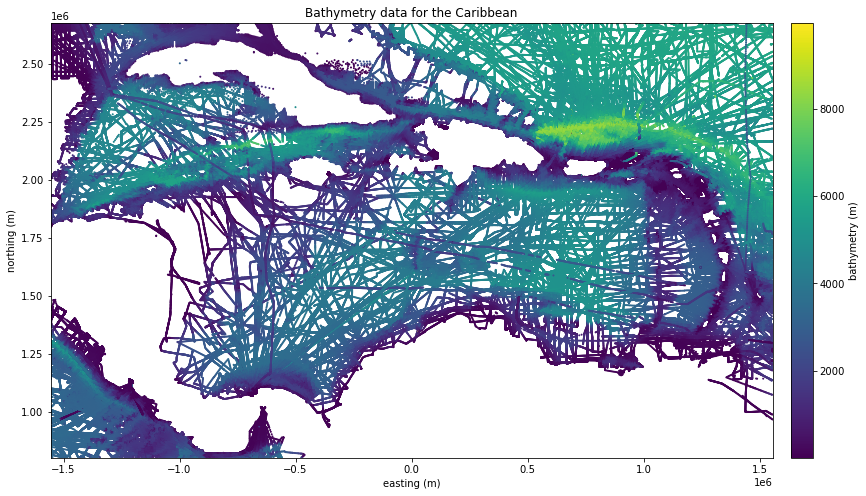

In [6]:
plt.figure(figsize=(16, 8))
plt.title("Bathymetry data for the Caribbean")
plt.scatter(*coordinates, c=data.depth_m, s=1)
plt.colorbar(label="bathymetry (m)", pad=0)
plt.axis("scaled")
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.xlabel("easting (m)")
plt.ylabel("northing (m)")

## Export

Set the export precision for each column by converting them to strings prior to saving the CSV.

In [7]:
export = data.copy()
# Meter level precision for coordinates and depth. 
# This is a very conservative estimate of actual precision.
export["longitude"] = export.longitude.map(lambda x: "{:.5f}".format(x))
export["latitude"] = export.latitude.map(lambda x: "{:.5f}".format(x))
export["depth_m"] = export.depth_m.map(lambda x: "{:.0f}".format(x))
export.head()

,survey_id,latitude,longitude,depth_m
0,FM0501,23.13070,-87.99680,75
1,FM0501,23.11940,-87.98640,75
2,FM0501,23.10810,-87.97610,73
3,FM0501,23.09670,-87.96580,73
4,FM0501,23.08540,-87.95540,73


Save the data to a file, calculate it's size and checksums.

In [8]:
fname = "bathymetry-caribbean.csv.xz"
export.to_csv(fname, index=False)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

size: 7.805232 Mb
md5:a7332aa6e69c77d49d7fb54b764caa82
sha256:9adaa2ead1cd354206235105489b511c4c46833b2e137a3eadc917243d16f09e


Try loading the data back to see if it works.

In [9]:
pd.read_csv(fname)

,survey_id,latitude,longitude,depth_m
0,FM0501,23.13070,-87.99680,75
1,FM0501,23.11940,-87.98640,75
2,FM0501,23.10810,-87.97610,73
3,FM0501,23.09670,-87.96580,73
4,FM0501,23.08540,-87.95540,73
...,...,...,...,...
1938090,EW0003,9.92284,-84.72557,20
1938091,EW0003,9.92282,-84.72565,20
1938092,EW0003,9.92283,-84.72570,20
1938093,EW0003,9.92284,-84.72574,21


## Try out some processing

Experiment with some processing functions to see if the results are interesting (for documentation) and can calculte in a reasonable amount of time (suitable for CI).

Block reduce and plot to check how long that would take.

In [10]:
%%time
spacing = 10e3
coordinates_mean, bathymetry_mean = vd.BlockReduce(np.median, spacing=spacing).filter(coordinates, data.depth_m)
_, bathymetry_std = vd.BlockReduce(np.std, spacing=spacing).filter(coordinates, data.depth_m)

CPU times: user 2.11 s, sys: 6.62 ms, total: 2.12 s
Wall time: 2.13 s


In [11]:
bathymetry_mean.size

34550

That's suitable for block reductions, trends, and nearest neighbor interpolations. For plain spline interpolation, we can always take a subsection of the data (around an island or the trench).

(801097.9844860577, 2675448.094929717)

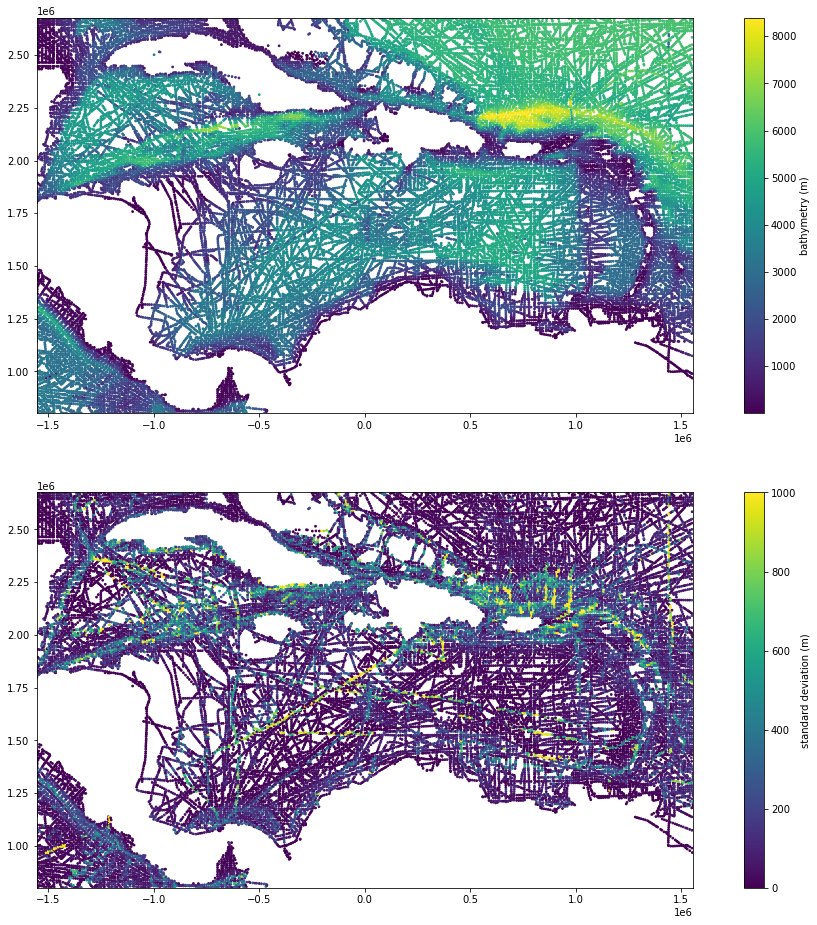

In [12]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.scatter(*coordinates_mean, c=bathymetry_mean, s=3)
plt.colorbar(label="bathymetry (m)", pad=0)
plt.axis("scaled")
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.subplot(2, 1, 2)
plt.scatter(*coordinates_mean, c=bathymetry_std, s=3, vmax=1000)
plt.colorbar(label="standard deviation (m)", pad=0)
plt.axis("scaled")
plt.xlim(*region[:2])
plt.ylim(*region[2:])